In [1]:
!pip install astral

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from astral import Astral
import datetime

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
import plotly.graph_objs as go

#warning library
import warnings
warnings.filterwarnings('ignore')

Astral a Python module which calculates<p>

Times for various positions of the sun: dawn, sunrise, solar noon, sunset, dusk, solar elevation, solar azimuth and rahukaalam.
The phase of the moon. Which is very helpful for finding relation between energy dissipated and time

In [3]:
a = Astral()
a.solar_depression = 'civil'

city = a['London']

## Exploratory Data Analysis

I use another related data which is of uk bank holidays to find a relation between energy and holidays. Let's see if there any between them


In [4]:
data = pd.read_csv("../input/uk-meters-tcs/Power-Networks-LCL.csv")
data_holidays = pd.read_csv('../input/smart-meters-in-london/uk_bank_holidays.csv')

In [5]:
data['stdorToU'].value_counts()

Std    999971
Name: stdorToU, dtype: int64

stdorToU have uniform values across complete data. So i conclude to drop that column as it don't contribute in prediction any relation

In [6]:
data.drop(['stdorToU'],axis=1,inplace=True)

In [7]:
'''Getting day and date by datetime given in column of dataset'''


day=[]
actual_date=[]

date=data['DateTime']
dates=date.tolist()
for date in dates:
    a,b=date.split()
    c=datetime.datetime.strptime(a,'%Y-%m-%d').strftime('%A')
    day.append(c)
    actual_date.append(a)
    
data['day']=day
data['date']=actual_date

In [8]:
#converting date time in proper format so that we can extract hour and minute
data.DateTime = pd.to_datetime(data.DateTime, format='%Y-%m-%d %H:%M:%S')

In [9]:
#Getting hour and minute from datetime column

data['hour'] = data.DateTime.dt.hour
data['minute'] = data.DateTime.dt.minute

Converting our hour and minutes format from **10.30 PM** to **2230**

In [10]:
'''Changing hour to double number format. 
   Like 10->10 and 3->03'''

hr=[]
for x in data['hour']:
    y = f'{x:02}'
    hr.append(y)

data['hour']=hr

In [11]:
'''Changing minute to double number format. 
   Like 30->30 and 0->00'''

mint=[]
for x in data['minute']:
    y = f'{x:02}'
    mint.append(y)

data['minute']=mint

In [12]:
data['time']=data['hour']+data['minute']
data.drop(['hour','minute'],axis=1,inplace=True)

data.head()

,LCLid,DateTime,KWh,Acorn,Acorn_grouped,day,date,time
0,MAC000002,2012-10-12 00:30:00,0.0,ACORN-A,Affluent,Friday,2012-10-12,0030
1,MAC000002,2012-10-12 01:00:00,0.0,ACORN-A,Affluent,Friday,2012-10-12,0100
2,MAC000002,2012-10-12 01:30:00,0.0,ACORN-A,Affluent,Friday,2012-10-12,0130
3,MAC000002,2012-10-12 02:00:00,0.0,ACORN-A,Affluent,Friday,2012-10-12,0200
4,MAC000002,2012-10-12 02:30:00,0.0,ACORN-A,Affluent,Friday,2012-10-12,0230


In [13]:
#Now drop previous DateTime
data.drop(['DateTime'],axis=1,inplace=True)

In [14]:
housecount = data.groupby('date')[['LCLid']].nunique()
housecount = housecount.reset_index()


fig = {"data" : [{"x" : housecount.date,"y" : housecount.LCLid,
                  "name" : "Total Run",
                  "line": {"width" : 5},"type" : "scatter","mode" : "lines" }],
       
        "layout" : {"title": "Sample of Houses per Day"}}

iplot(fig)


**As shown in figure most consistent data is of 2013**

### Average Energy Consumption

In [15]:
energy_data_date = data.groupby('date').agg({'KWh':'sum','time':'count'})
energy_data_date = energy_data_date.reset_index()
energy_data_date['net'] = energy_data_date['KWh']/energy_data_date['time']

In [16]:
energy_data_date.sample(5)

,date,KWh,time,net
261,2012-08-23,185.713,1152,0.161209
116,2012-03-31,231.846,1008,0.230006
307,2012-10-08,250.208,1344,0.186167
649,2013-09-15,259.903,1344,0.193380
670,2013-10-06,258.644,1344,0.192443


In [17]:
fig = {"data" : [{"x" : energy_data_date.date,"y" : energy_data_date.net,
                  "name" : "Total Run","line": {"width" : 2},
                  "type" : "scatter","mode" : "lines" }],
       
        "layout" : {"title": "Average Energy Comsumption per Day"}}

iplot(fig)

### Data related to sum, median, mean, min, max, std and count of energy consumption per House

In [18]:
energy_data = data.groupby('LCLid').agg({'KWh':['sum','median','mean','min','max','std','count']})

In [19]:
energy_data=energy_data.reset_index()
energy_data.columns = energy_data.columns.droplevel()
energy_data = energy_data.rename(columns={'':'LCLid'})

 ### Suspicious House or energy efficient

In [20]:
energy_data[energy_data['LCLid']=='MAC000004']

,LCLid,sum,median,mean,min,max,std,count
2,MAC000004,1120.788,0.0,0.035383,0.0,1.065,0.073146,31676


Let's look at energy features of house having LCLid0 'MAC000004', median of  that house is 0 which implies more that half of reading per half hour is equal to 0.

In [21]:
data4 = data[data['LCLid']=='MAC000004']
data40 = data4[data4['KWh']==0]

In [22]:
print('Total samples of house with id MAC000004 : ' + str(len(data4)))
print('Samples with 0.0 energy consumption of house with id MAC000004 : ' + str(len(data40)))
print('\n')
print(len(data40)/len(data4))

Total samples of house with id MAC000004 : 31676
Samples with 0.0 energy consumption of house with id MAC000004 : 24307


0.767363303447405


So every 3 out of 4 readings of LCLid MAC000004 house contain 0 values (Maybe using energy from solar/any other source :p)

In [23]:
data_id4 = data[data['LCLid']=='MAC000004']
data_id4 = data_id4.groupby('date').agg({'KWh':'sum'})
data_id4=data_id4.reset_index()

In [24]:
fig = {"data" : [{"x" : data_id4.date,"y" : data_id4.KWh,
                  "name" : "Total Run","line": {"width" : 2},
                  "type" : "scatter","mode" : "lines" }],
       
        "layout" : {"title": "Average Energy Comsumption per Day of House LCLid MAC000004"}}

iplot(fig)

Some observations regarding this house:
* Only one day consumption is equal to 0
* Almost equal consumption per day (not affected by seasons and weathers)

In [25]:
print("Consumption greater than 3 KWh : "+ str(len(data_id4[data_id4['KWh']>3]))+" times")
print("Consumption equal to 0 KWh : "+ str(len(data_id4[data_id4['KWh']==0]))+" time")

Consumption greater than 3 KWh : 11 times
Consumption equal to 0 KWh : 1 time


In [26]:
energy_data.sort_values(['mean'],ascending=False).head(3)

,LCLid,sum,median,mean,min,max,std,count
27,MAC000034,22145.137995,0.151,0.566821,0.023,6.528,1.140982,39069
7,MAC000010,13786.276997,0.410,0.550394,0.113,4.189,0.430959,25048
28,MAC000035,18473.795997,0.381,0.473408,0.072,3.218,0.382125,39023


**Hence, houses with maximum energy consumption are MC0000034, MC0000010 and MC0000035**

In [27]:
data_id34 = data[data['LCLid']=='MAC000034']
data_id34 = data_id34.groupby('date').agg({'KWh':'sum'})
data_id34 = data_id34.reset_index()

In [28]:
fig = {"data" : [{"x" : data_id34.date,"y" : data_id34.KWh,
                  "name" : "Total Run","line": {"width" : 2},
                  "type" : "scatter","mode" : "lines" }],
       
        "layout" : {"title": "Average Energy Comsumption per Day of House LCLid MAC000004"}}

iplot(fig)

* From June to November each year, consumption is under is 10KWh
* Variation is different from seasonal weathers from UK

### Clustereing of Houses

In [29]:
energy_data_cluster = energy_data.copy()
energy_data_cluster.drop(['count'],axis=1,inplace=True)

In [30]:
walle = energy_data_cluster.iloc[:,1:]

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(walle)
pcdf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

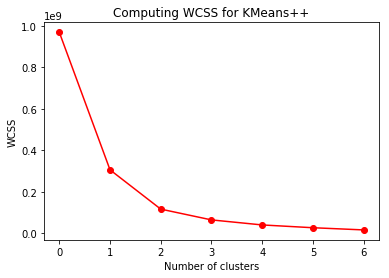

In [32]:
vals = pcdf.values

from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using WCSS
wcss = []
for ii in range( 1, 8 ):
    kmeans = KMeans(n_clusters=ii, init="k-means++", n_init=10, max_iter=300) 
    kmeans.fit_predict( vals )
    wcss.append( kmeans.inertia_ )
    
plt.plot( wcss, 'ro-', label="WCSS")
plt.title("Computing WCSS for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

So roughly there are are 2 cluster in which we can divide our houses based on energy features 

In [33]:
kmean = KMeans(n_clusters=2,)
y_kmeans = kmean.fit_predict(vals)

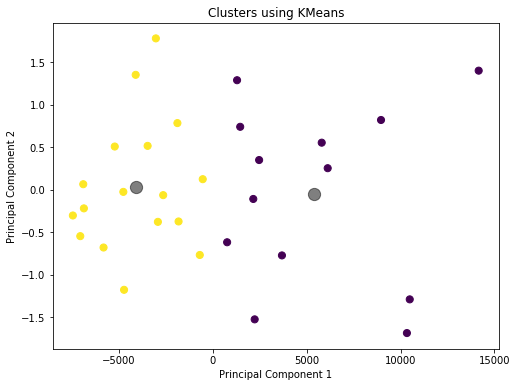

In [34]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(pcdf.iloc[:, 0], pcdf.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmean.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=150, alpha=0.5)
plt.title('Clusters using KMeans')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.show()


### Data Per House Per Day

In [35]:
energy_data_house = data.groupby(['LCLid','date']).agg({'KWh':['sum','median','mean','min','max','std','count']})

In [36]:
energy_data_house=energy_data_house.reset_index()
energy_data_house.columns = energy_data_house.columns.droplevel()
energy_data_house.columns = ['LCLid','date', 'sum', 'median', 'mean', 'min', 'max', 'std','count']

In [37]:
energy_data_house.sample(4)

,LCLid,date,sum,median,mean,min,max,std,count
3490,MAC000008,2013-02-28,24.789,0.4055,0.516437,0.261,1.610,0.312686,48
5736,MAC000012,2014-01-01,1.160,0.0175,0.024167,0.000,0.056,0.023702,48
18059,MAC000032,2014-02-01,17.412,0.0660,0.362750,0.000,2.511,0.626769,48
3066,MAC000007,2013-10-27,9.804,0.1240,0.200082,0.027,1.608,0.242523,49


In [38]:
acorn = data[['LCLid','Acorn','Acorn_grouped']]
acorn = acorn.drop_duplicates()
acorn_data = acorn['Acorn'].value_counts()

In [39]:
acorn_data = acorn_data.to_frame()
acorn_data = acorn_data.reset_index()
acorn_data.columns = ['Acorn','Count']

In [40]:
data_graph = [go.Bar(x=acorn_data['Acorn'].values,y=acorn_data['Count'].values,
                name='Total Matches',text=acorn_data['Acorn'].values,
                marker=dict(color='rgb(255,140,0)',
                            line=dict(color='rgb(8,48,107)',width=1.5,)),opacity=0.7)]

layout = go.Layout(title='Distribution of houses with Acorn',xaxis = dict(tickmode='linear',title="No. of Houses"),
                   yaxis=dict(title='Acorn'))
fig = go.Figure(data=data_graph, layout=layout)
iplot(fig)

In [41]:
acorn_group = acorn.sort_values('Acorn_grouped')

In [42]:
acorn_group = acorn_group['Acorn_grouped'].value_counts().to_frame().reset_index()
acorn_group.columns = ['Acorn_grouped','Count']

In [43]:
data_graph = [go.Bar(x=acorn_group['Acorn_grouped'].values,y=acorn_group['Count'].values,
                name='Total Matches',text=acorn_data['Acorn'].values,
                marker=dict(line=dict(color='rgb(8,48,107)',width=1.5,)),opacity=0.7)]

layout = go.Layout(title='Distribution of houses with Acorn Groups',xaxis = dict(tickmode='linear',title="No. of Houses"),
                   yaxis=dict(title='Acorn'))
fig = go.Figure(data=data_graph, layout=layout)
iplot(fig)

In [44]:
energy_data_house['date'] = pd.to_datetime(energy_data_house['date'])
energy_data_house_less = energy_data_house[energy_data_house['count'] < 48]

In [45]:
print("Data have counts less than 48 : "+str(len(energy_data_house_less)))
print("Percentage of this data(less than 48) : "+str(round(len(energy_data_house_less)/len(energy_data_house),3)))

Data have counts less than 48 : 168
Percentage of this data(less than 48) : 0.008


In [46]:
energy_data_house_less.groupby(['date']).agg({'LCLid': 'count'}).head(5).reset_index()

,date,LCLid
0,2011-12-06,1
1,2011-12-07,18
2,2011-12-13,4
3,2011-12-21,1
4,2011-12-24,1


In [47]:
print(len(energy_data_house_less.groupby(['date'])))
print(len(energy_data_house_less['LCLid'].unique()))

107
30


### How much evenly and in what volume households are represented (quantitatively) for those measurements are taken throughout the study period

We plot two curves on one graph:

* The number of counters (from which the readings were taken in one day) during the entire observation period (X: dates; Y - the number of counters per day)
* Total recorded by the meters electricity consumption per day during the entire observation period (X: dates; Y - total energy consumption per day)

Because the fraction of incomplete measurements is approximately 1%, it is possible to neglect them in order to reduce the influence on the error of daily data.

In [48]:
energy_data_house_hh = (energy_data_house.loc[energy_data_house['count'] == 48, 
                        ['LCLid','date','sum']].dropna().groupby('date').agg({'LCLid': 'count', 'sum': 'sum'}))
energy_data_house_hh.head()

,LCLid,sum
date,,
2011-12-07,1,5.848
2011-12-08,19,248.374
2011-12-09,19,216.327
2011-12-10,19,246.168
2011-12-11,19,277.649


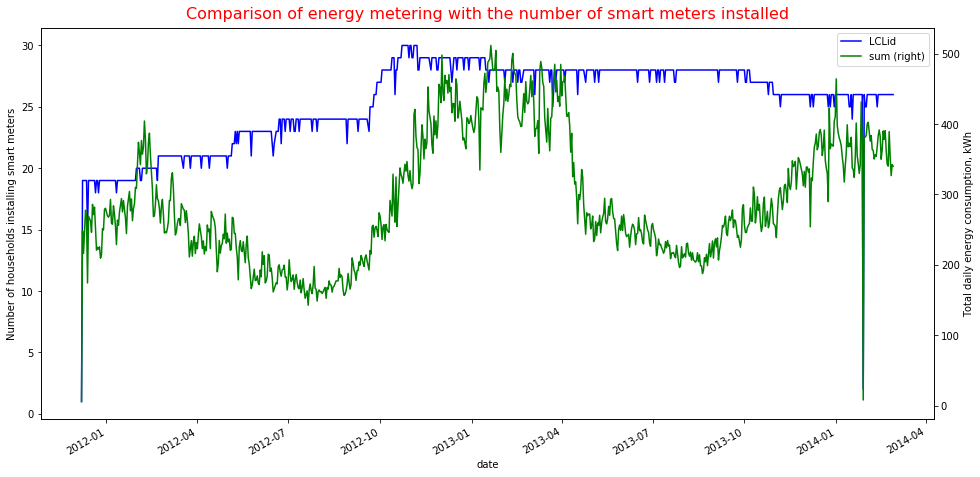

In [49]:
fig,ax=plt.subplots(figsize=(16,8))
energy_data_house_hh.plot(ax=ax, secondary_y=['sum'], style=['b','g'])
ax.set_ylabel('Number of households installing smart meters')
ax.right_ax.set_ylabel('Total daily energy consumption, kWh');
ax.set_title('Comparison of energy metering with the number of smart meters installed', color = 'red', size = 16, verticalalignment='bottom')
plt.show()

The graph energy consumption not only on the increase in the number of meters but also the seasonal factor is visible while calculating energy consumption.

### We define the time interval (window), which we will consider sufficient to construct a sample of observations

Statistically sound (sufficient) can be considered the observation period, covering all seasonal fluctuations in weather conditions, and other cyclically repeating factors that affect energy consumption. It is logical that for such a period you can take one calendar year. Of the entire sample, the data for 2013 are most suitable for these purposes, as the most complete, because the measurements for the remaining years are either not fully presented, or not all seasons and months (2011, 2014).

In [50]:
begin_date = datetime.datetime(2013,1,1)
end_date = datetime.datetime(2013,12,31)

In [51]:
energy_data_house_window = (energy_data_house[(energy_data_house['count'] == 48) & 
                                              (energy_data_house['date'] >= begin_date) &  (energy_data_house['date'] <= end_date)].dropna())
energy_data_house_window.head()

,LCLid,date,sum,median,mean,min,max,std,count
81,MAC000002,2013-01-01,10.800,0.1925,0.225000,0.076,0.886,0.164066,48
82,MAC000002,2013-01-02,13.300,0.2365,0.277083,0.073,1.078,0.189625,48
83,MAC000002,2013-01-03,10.074,0.1955,0.209875,0.075,1.098,0.154632,48
84,MAC000002,2013-01-04,9.857,0.1815,0.205354,0.072,0.662,0.132950,48
85,MAC000002,2013-01-05,11.171,0.1975,0.232729,0.075,1.181,0.186772,48


In [52]:
print("No. of Houses in window : "+str(len(energy_data_house_window.groupby('LCLid'))))

No. of Houses in window : 29


As a result of only narrowing the period of (full) observations (observation windows) to one year 2013, the number of households in the data set decreased to 29 (that is, we “lost” 1 households)

### We exclude from consideration that households for which the number of days of observation (data collection) in 2013 is significantly less than the number of days in a year

Suppose that a sufficient observation period is the number of working days and days off per year (except for holidays, we use the data from the uk_bank_holidays.csv file).

In [53]:
data_holidays['Bank holidays'] = pd.to_datetime(data_holidays['Bank holidays'])
work_period = 365 - len(data_holidays[(data_holidays['Bank holidays'] >= begin_date) &  (data_holidays['Bank holidays'] <= end_date)])
print("Work period : "+str(work_period))

Work period : 357


Thus, we received 8 holidays, and, accordingly, a sufficient observation period will be 357 days.<p>

Let's test our hypothesis about the influence of holidays on the observation period. We rank all days of the year to increase the number of households involved in measuring energy consumption. If our hypothesis is true, then the first (with the smallest data) will be holidays.

In [54]:
from matplotlib.ticker import AutoMinorLocator

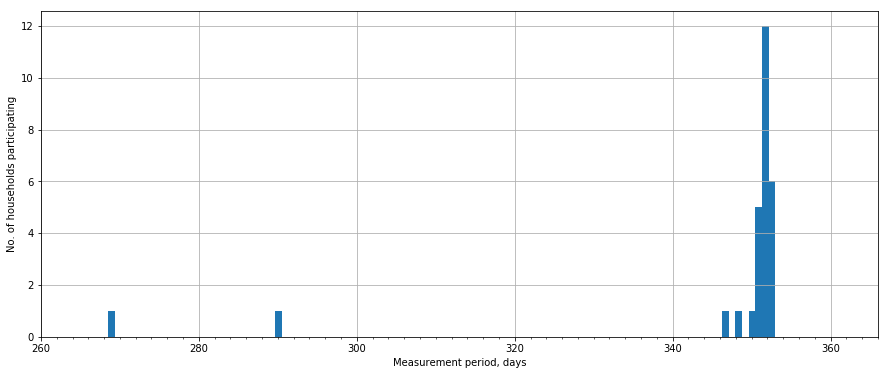

In [55]:
q_period = energy_data_house_window.groupby('LCLid').count()
fig,ax=plt.subplots(figsize=(15,6))
plt.xlim(260, 366)
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
q_period['date'].hist(ax=ax, bins = 400);
ax.set_xlabel('Measurement period, days');
ax.set_ylabel('No. of households participating');

Most households in 2013 and 2012 had an observation period (measurement period for electricity consumption) of 345 to 360 days. Interestingly, this result numerically coincided with our previous assumption (on the sufficiency of a period consisting of all days in a year except holidays)

### For each of the consumer groups we will analyze the daily energy consumption during 2013

* In total per group and in terms of one household, taking into account daylight hours (daylight hours for each day are defined as the interval between dawn and sunset, night - as the interval between sunset and dawn)<p>
    
separately for tariff groups:
* T1 - peak load
* T2 - average load
* T3 - low load

I draw conclusions about the periods of the day with the highest energy consumption, and about the effect on the energy consumption of the selected tariff in each of the five groups.<p>

Define the constants for T1, T2, T3, in accordance with generally accepted practice:<p>

* T1 - from 07:00 to 10:00 and from 17:00 to 21:00,<br>
* T2 - from 10:00 to 17:00 and from 21:00 to 23:00,<br>
* T3 - from 23:00 to 24:00 and from 00:00 to 07:00

In [56]:
T1_default = [[datetime.timedelta(hours=7, minutes=0),  datetime.timedelta(hours=9, minutes=59)],
              [datetime.timedelta(hours=17, minutes=0), datetime.timedelta(hours=20, minutes=59)]]
T2_default = [[datetime.timedelta(hours=10, minutes=0), datetime.timedelta(hours=16, minutes=59)],
              [datetime.timedelta(hours=21, minutes=0), datetime.timedelta(hours=22, minutes=59)]]
T3_default = [[datetime.timedelta(hours=0, minutes=0),  datetime.timedelta(hours=6, minutes=59)],
              [datetime.timedelta(hours=23, minutes=0), datetime.timedelta(hours=23, minutes=59)]]

In [57]:
hour_data = data[['LCLid','date','time','KWh']]

In [58]:
table = pd.pivot_table(hour_data, values='KWh', index=['LCLid', 'date'],columns=['time'])
data_table = table.copy()

data_table = data_table.reset_index()
data_table['date']=pd.to_datetime(data_table['date'])

In [59]:
'''For getting sunrise time of particular date'''

y=[]
for x in data_table['date']:
    sun = city.sun(date=x, local=True)
    x = (str(sun['sunrise']))
    x = (x[11:19])
    y.append(x)
    
data_table['sunriseTime']=y

In [60]:
'''For getting sunset time of particular date'''

y=[]
for x in data_table['date']:
    sun = city.sun(date=x, local=True)
    x = (str(sun['sunset']))
    x = (x[11:19])
    y.append(x)
    
data_table['sunsetTime']=y

In [61]:
# Selecting data in window
data_table_window = data_table[(data_table['date'] >= begin_date) &  (data_table['date'] <= end_date)]

In [62]:
print('Data with duplicates :'+str(len(data_table_window)))
print('---------------------')
data_table_window=data_table_window.dropna()
print('Data without duplicates :'+str(len(data_table_window)))

Data with duplicates :10089
---------------------
Data without duplicates :10047


Calc_power function calculates in one day for one household daily (from sunrise to sunset), night and total electricity consumption, as well as energy consumption in tariff intervals t1, t2, t3<p>
    
The function returns the calculated values as a set of six elements in the Series wrapper.
The function receives as arguments
* row - row (Series) of the table with information on half-hour electricity consumption by one household in one day, in the data set format data_hh_block_all_sun
* t1 - time interval in days corresponding to peak load, default T1_default
* t2 - time interval in days corresponding to the average load, by default T2_default
* t3 - time interval in days corresponding to a low load, by default T3_default

In [63]:
def calc_power (row, t1 = T1_default, t2 = T2_default, t3 = T3_default):
    
    sunriseTime = datetime.datetime.strptime(row['sunriseTime'],'%H:%M:%S')
    sunsetTime = datetime.datetime.strptime(row['sunsetTime'], '%H:%M:%S')
    
    begin_index = datetime.timedelta(hours = sunriseTime.hour, minutes = sunriseTime.minute)//datetime.timedelta(minutes=30)
    end_index = datetime.timedelta(hours = sunsetTime.hour, minutes = sunsetTime.minute)//datetime.timedelta(minutes=30)
    day_power = sum(row.iloc[begin_index + 2: end_index +2])
    night_power = sum(row.iloc[2: begin_index +2]) + sum(row.iloc[end_index +2:-2])
    
    delta_time = datetime.timedelta(minutes=30)
    indexT1 = [ [t[0]//delta_time, t[1]//delta_time + 1] for t in t1]
    indexT2 = [ [t[0]//delta_time, t[1]//delta_time + 1] for t in t2]
    indexT3 = [ [t[0]//delta_time, t[1]//delta_time + 1] for t in t3]
    
    T1_power = sum([sum(row.iloc[idx[0]+2: idx[1]+2]) for idx in indexT1])
    T2_power = sum([sum(row.iloc[idx[0]+2: idx[1]+2]) for idx in indexT2])
    T3_power = sum([sum(row.iloc[idx[0]+2: idx[1]+2]) for idx in indexT3])
    
    return pd.Series([day_power, night_power, day_power + night_power, T1_power, T2_power, T3_power])

For all households, we calculate the daily, night and total electricity consumption, as well as in the tariff intervals T1, T2, T3

In [64]:
data_table_window[['day_power', 'night_power', 'summary_power', 'T1_power', 'T2_power', 'T3_power']] = data_table_window.apply(calc_power, axis=1)
data_table_window.head(3)

time,LCLid,date,0000,0030,0100,0130,0200,0230,0300,0330,...,2300,2330,sunriseTime,sunsetTime,day_power,night_power,summary_power,T1_power,T2_power,T3_power
81,MAC000002,2013-01-01,0.219,0.241,0.191,0.235,0.182,0.229,0.194,0.201,...,0.253,0.258,08:05:28,16:02:19,3.368,7.432,10.800,3.670,4.294,2.836
82,MAC000002,2013-01-02,0.253,0.211,0.347,0.280,0.261,0.229,0.258,0.125,...,0.245,0.255,08:05:21,16:03:22,4.428,8.872,13.300,4.145,6.043,3.112
83,MAC000002,2013-01-03,0.196,0.239,0.235,0.195,0.239,0.201,0.206,0.133,...,0.238,0.286,08:05:11,16:04:28,2.743,7.331,10.074,3.680,3.612,2.782


In [65]:
data_acorn_group = data[['LCLid', 'Acorn_grouped']]
data_acorn_group=data_acorn_group.drop_duplicates()

In [66]:
data_table_sun_merge = data_table_window.merge(data_acorn_group, on='LCLid',how='outer')

We group all households according to Acorn_grouped, and for each group we calculate the total values ​​of daily, night and daily electricity consumption

In [67]:
data_hh_block_all_grouped = data_table_sun_merge.groupby('Acorn_grouped').agg({'LCLid': 'unique','day_power': 'sum', 'night_power':'sum', 'summary_power': 'sum'})
data_hh_block_all_grouped.head()

,LCLid,day_power,night_power,summary_power
Acorn_grouped,,,,
ACORN-U,[MAC000023],2892.926999,2108.279001,5001.206000
Adversity,"[MAC000003, MAC000006, MAC000009, MAC000011, M...",13995.296999,18450.426001,32445.723000
Affluent,"[MAC000002, MAC000004, MAC000012, MAC000018, M...",24037.308998,29952.230998,53989.539996
Comfortable,"[MAC000007, MAC000008, MAC000010, MAC000020, M...",13012.826999,10231.005997,23243.832996


In the LCLid column of the obtained data set (data_data_hh_block_all_grouped), we write down the number of households in each group

In [68]:
data_hh_block_all_grouped['LCLid'] = data_hh_block_all_grouped.LCLid.transform(lambda x: len(x))
data_hh_block_all_grouped.head()

,LCLid,day_power,night_power,summary_power
Acorn_grouped,,,,
ACORN-U,1,2892.926999,2108.279001,5001.206000
Adversity,11,13995.296999,18450.426001,32445.723000
Affluent,13,24037.308998,29952.230998,53989.539996
Comfortable,5,13012.826999,10231.005997,23243.832996


The print_percent (ax, data, total) function prints% of each share of total on stacked (bar) diagrams
    drawn on a data set (DataFrame) data. The number of shares in the diagram corresponds to the number of columns in data.<p>
The function receives as arguments
* data - a data set, each column of which corresponds to one share in the diagram
* total - the total value of all shares (the sum of the columns in the data set)

In [69]:
def print_percent(ax, data, total):
    df_percent = data.div(total, 0)*100
    for n in df_percent:
        for i, (cs, ab, pc, tot) in enumerate(zip(data.cumsum(1)[n], data[n], df_percent[n], total)):
            ax.text(i, cs - ab/2, str(np.round(pc, 1)) + '%', va='center', ha='center')

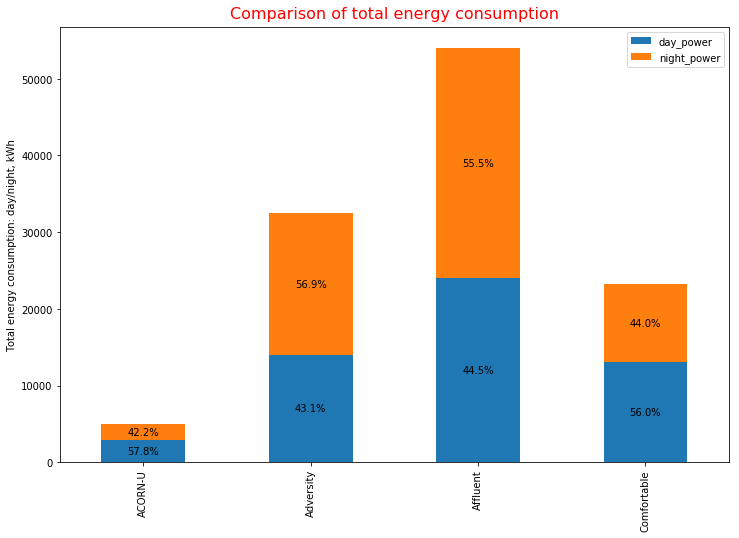

In [70]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Total energy consumption: day/night, kWh')
ax.set_title('Comparison of total energy consumption', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_grouped[['day_power', 'night_power']], data_hh_block_all_grouped['summary_power'])
data_hh_block_all_grouped[['day_power', 'night_power']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

We construct a pie chart showing the distribution of the shares of electricity of each group in the total daily and total night consumption

The draw_pie function (data, titles, labels = [], size = (15,7)) draws several pie charts
    by a data set (DataFrame) data in two columns per sheet. The number of charts corresponds to the number of columns in data.<p>
    
The function receives as arguments
* data - a data set, each column of which must be displayed on a separate diagram
* titels - chart titles
* labels - an optional parameter - labels on the diagrams (in case the labels need to be replaced by default)
* size - an optional parameter sets the size of the canvas (default is 15x15)
* pair - optional parameter (True / False). When pair == True does grouping pairs of labels (labels) by the tint of the same color each pair. The default is False.

In [71]:
def draw_pie (data, titles, labels=[], size = (15,7), pair = False):
    colormap = None
    if len(labels)==0:
        labels = data.index.values
    if pair:
        colors = list(plt.rcParams.get('axes.color_cycle', list('bgrcmyk')))
        colormap =  []
        for color in colors:
            colormap.append(matplotlib.colors.to_rgba(color, 1))
            colormap.append(matplotlib.colors.to_rgba(color, 0.7))
            if (len(colormap)>= len(labels)):
                break
    for i, T in enumerate(data.columns):
        if i>=len(titles):
            titles.append(data.columns[i])
        ax = plt.subplot2grid( ((len(data.columns)-1)//2 + 1, 2), (i//2, (i+2)%2) )
        ax.set_title(titles[i], color = 'red', size = 16, verticalalignment='bottom');
        data[T].plot.pie(ax=ax, autopct='%.2f%%', subplots=False, 
                        legend = False,   figsize=size, colors = colormap,
                        labels = labels) 
        ax.set_ylabel('')

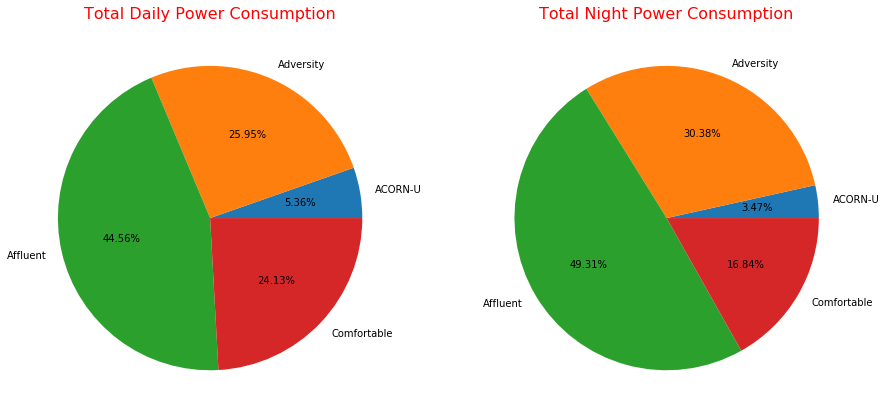

In [72]:
draw_pie(data_hh_block_all_grouped[['day_power', 'night_power']], 
         ['Total Daily Power Consumption', 'Total Night Power Consumption'])

We calculate the average daily and night consumption (per household) for each group

In [73]:
data_hh_block_all_grouped['day_power_meam'] = data_hh_block_all_grouped.day_power/data_hh_block_all_grouped.LCLid
data_hh_block_all_grouped['night_power_meam'] = data_hh_block_all_grouped.night_power/data_hh_block_all_grouped.LCLid
data_hh_block_all_grouped.head()

,LCLid,day_power,night_power,summary_power,day_power_meam,night_power_meam
Acorn_grouped,,,,,,
ACORN-U,1,2892.926999,2108.279001,5001.206000,2892.926999,2108.279001
Adversity,11,13995.296999,18450.426001,32445.723000,1272.299727,1677.311455
Affluent,13,24037.308998,29952.230998,53989.539996,1849.023769,2304.017769
Comfortable,5,13012.826999,10231.005997,23243.832996,2602.565400,2046.201199


Let's build a bar chart of average energy consumption (day / night) in 2013 with a breakdown by ACORN group

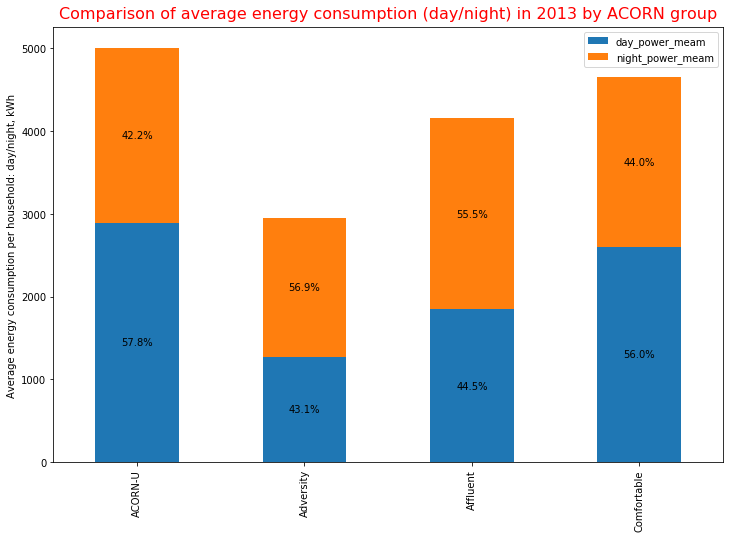

In [74]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Average energy consumption per household: day/night, kWh')
ax.set_title('Comparison of average energy consumption (day/night) in 2013 by ACORN group', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_grouped[['day_power_meam', 'night_power_meam']], data_hh_block_all_grouped['summary_power']/data_hh_block_all_grouped.LCLid)
data_hh_block_all_grouped['night_power_meam'] = data_hh_block_all_grouped.night_power/data_hh_block_all_grouped.LCLid
data_hh_block_all_grouped.head()
data_hh_block_all_grouped[['day_power_meam', 'night_power_meam']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

We construct a pie chart showing the distribution of the shares of energy consumption on average per household in each group in the daytime and at night

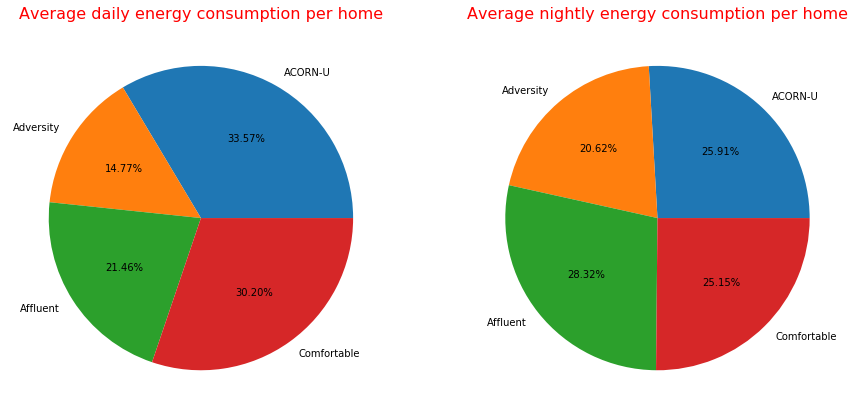

In [75]:
draw_pie(data_hh_block_all_grouped[['day_power_meam', 'night_power_meam']], 
         ['Average daily energy consumption per home', 'Average nightly energy consumption per home'])


The presented diagrams clearly show that:
* Total energy consumption in each of the groups of households is determined by its number. We have already noted this fact.
* The shares of day and night electricity consumption (in daylight and dark) in the average annual measurement are practically equal to each other in all groups of households
* Revealing the fact that the share of day / night energy consumption is approximately 50% in all groups of households excludes the possibility of their additional ranking depending on the ownership of the household in one group or another. We can only state the previously established result that in the ranking of energy consumption per household, the most well-off part breaks ahead. Further, with a slight gradient, the middle class and the less well off go down.

In [76]:
data_hh_block_all_tariff = data_table_sun_merge.groupby(['Acorn_grouped']).agg({'LCLid': 'unique','summary_power': 'sum', 'T1_power':'sum', 'T2_power':'sum', 'T3_power':'sum'})
data_hh_block_all_tariff.head(12)

,LCLid,summary_power,T1_power,T2_power,T3_power
Acorn_grouped,,,,,
ACORN-U,[MAC000023],5001.206000,2017.125000,2323.196999,660.884000
Adversity,"[MAC000003, MAC000006, MAC000009, MAC000011, M...",32445.723000,8659.093000,10710.300000,13076.330000
Affluent,"[MAC000002, MAC000004, MAC000012, MAC000018, M...",53989.539996,15158.384000,19972.166000,18858.989996
Comfortable,"[MAC000007, MAC000008, MAC000010, MAC000020, M...",23243.832996,8971.464998,9754.453998,4517.914000


In [77]:
data_hh_block_all_tariff['LCLid'] = data_hh_block_all_tariff.LCLid.transform(lambda x: len(x))
data_hh_block_all_tariff.head(12)

,LCLid,summary_power,T1_power,T2_power,T3_power
Acorn_grouped,,,,,
ACORN-U,1,5001.206000,2017.125000,2323.196999,660.884000
Adversity,11,32445.723000,8659.093000,10710.300000,13076.330000
Affluent,13,53989.539996,15158.384000,19972.166000,18858.989996
Comfortable,5,23243.832996,8971.464998,9754.453998,4517.914000


Let's build a bar chart of the total energy consumption in the tariff periods in 2013 by ACORN group:<p>

* T1 (7: 00-10: 00, 17: 00-21: 00)
* T2 (10: 00-17: 00, 21: 00-23: 00)
* T3 (23: 00-7: 00)


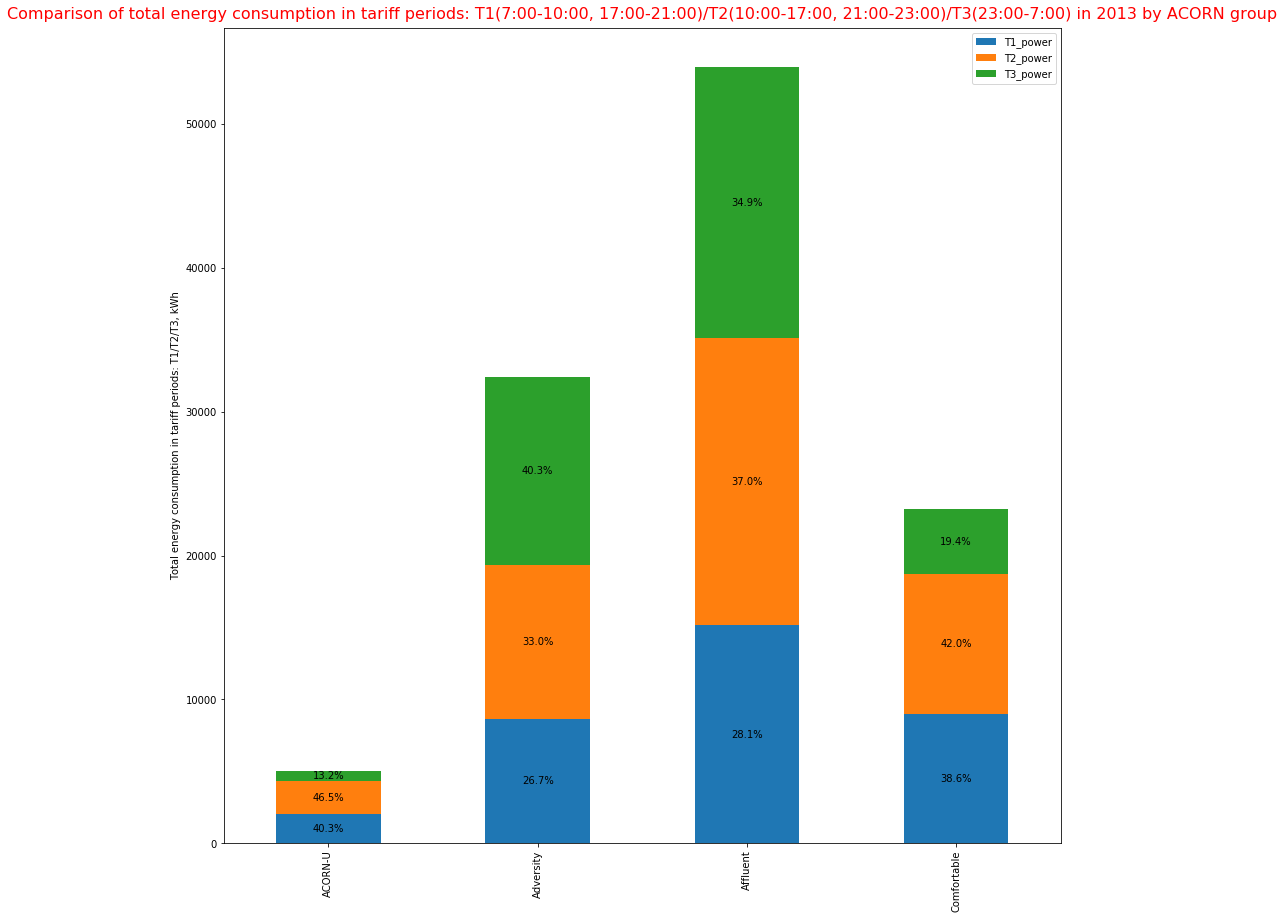

In [78]:
fig,ax=plt.subplots(figsize=(15,15))
ax.set_ylabel('Total energy consumption in tariff periods: T1/T2/T3, kWh')
ax.set_title('Comparison of total energy consumption in tariff periods: T1(7:00-10:00, 17:00-21:00)/T2(10:00-17:00, 21:00-23:00)/T3(23:00-7:00) in 2013 by ACORN group', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_tariff[['T1_power', 'T2_power', 'T3_power']], data_hh_block_all_tariff['summary_power'])
data_hh_block_all_tariff[['T1_power', 'T2_power', 'T3_power']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

In [79]:
data_hh_block_all_tariff['T1_power_meam'] = data_hh_block_all_tariff.T1_power/data_hh_block_all_tariff.LCLid
data_hh_block_all_tariff['T2_power_meam'] = data_hh_block_all_tariff.T2_power/data_hh_block_all_tariff.LCLid
data_hh_block_all_tariff['T3_power_meam'] = data_hh_block_all_tariff.T3_power/data_hh_block_all_tariff.LCLid
data_hh_block_all_tariff.head()

,LCLid,summary_power,T1_power,T2_power,T3_power,T1_power_meam,T2_power_meam,T3_power_meam
Acorn_grouped,,,,,,,,
ACORN-U,1,5001.206000,2017.125000,2323.196999,660.884000,2017.125000,2323.196999,660.884000
Adversity,11,32445.723000,8659.093000,10710.300000,13076.330000,787.190273,973.663636,1188.757273
Affluent,13,53989.539996,15158.384000,19972.166000,18858.989996,1166.029538,1536.320462,1450.691538
Comfortable,5,23243.832996,8971.464998,9754.453998,4517.914000,1794.293000,1950.890800,903.582800


Let us construct a bar graph of the average energy consumption per household in the tariff periods T1 / T2 / T3 in 2013 with a breakdown by ACORN groups

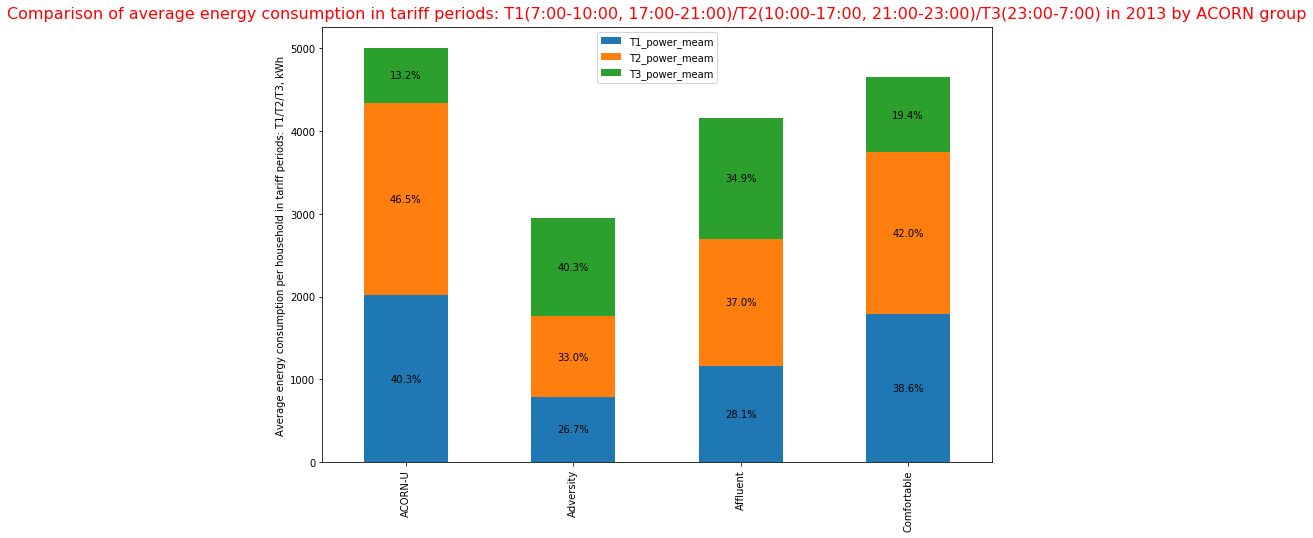

In [80]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Average energy consumption per household in tariff periods: T1/T2/T3, kWh')
ax.set_title('Comparison of average energy consumption in tariff periods: T1(7:00-10:00, 17:00-21:00)/T2(10:00-17:00, 21:00-23:00)/T3(23:00-7:00) in 2013 by ACORN group', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_tariff[['T1_power_meam', 'T2_power_meam', 'T3_power_meam']], data_hh_block_all_tariff['summary_power']/data_hh_block_all_tariff.LCLid)
data_hh_block_all_tariff[['T1_power_meam', 'T2_power_meam', 'T3_power_meam']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

## Forecasting Model

In [81]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [82]:
housecount=housecount.reset_index()
housecount['date'] = pd.to_datetime(housecount['date'])

In [83]:
energy = energy_data_house.groupby(['date'])[['sum']].sum().reset_index()
energy = energy.merge(housecount, on = ['date'])
energy['avg'] =  energy['sum']/energy['LCLid']
energy.head(2)

,date,sum,index,LCLid,avg
0,2011-12-06,2.947,0,1,2.947000
1,2011-12-07,143.160,1,19,7.534737


In [84]:
data_holidays['Bank holidays'] = pd.to_datetime(data_holidays['Bank holidays'])
data_holidays.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


In [85]:
weather_energy = energy.merge(data_holidays, left_on = 'date',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [86]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['date']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['date']).month
weather_energy.set_index(['date'],inplace=True)

In [87]:
model_data = weather_energy[['avg','holiday_ind']]

train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

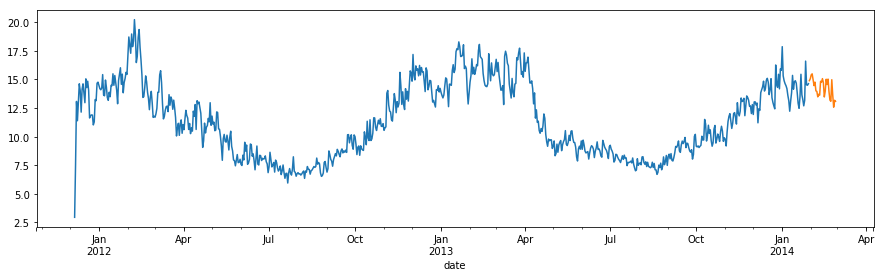

In [88]:
train['avg'].plot(figsize=(15,4))
test['avg'].plot(figsize=(15,4))
plt.show()

**Auto-correlation Plot** : it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

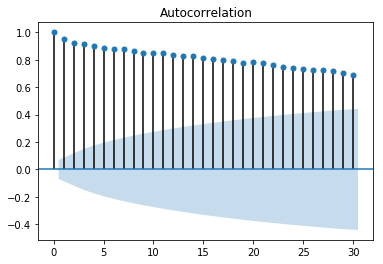

In [89]:
plot_acf(train.avg,lags=30)
plt.show()

**Partial cuto correlation function** : Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s))

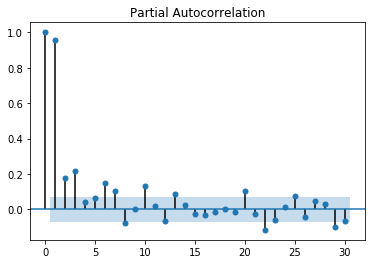

In [90]:
plot_pacf(train.avg,lags=30)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature'

In [91]:
t = sm.tsa.adfuller(train.avg, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.758444
p-value                          0.401279
#Lags Used                      21.000000
Number of Observations Used    764.000000
dtype: float64

p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [92]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [93]:
t  = sm.tsa.adfuller(difference(train.avg,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -5.776730e+00
p-value                        5.238444e-07
#Lags Used                     2.100000e+01
Number of Observations Used    7.630000e+02
dtype: float64

The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

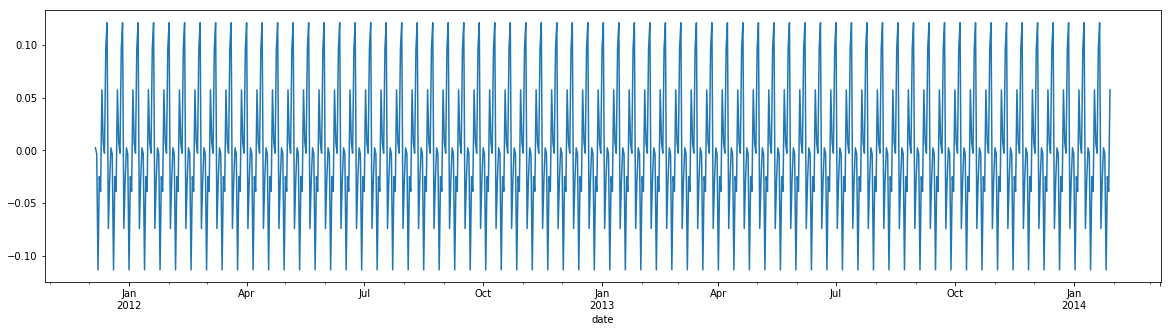

In [94]:
s = sm.tsa.seasonal_decompose(train.avg,freq=12)
s.seasonal.plot(figsize=(20,5))
plt.show()

In [95]:
endog = train['avg']
exog = sm.add_constant(train[['holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog,exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                avg   No. Observations:                  786
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -1149.109
Date:                            Wed, 21 Aug 2019   AIC                           2324.217
Time:                                    17:13:17   BIC                           2384.671
Sample:                                12-06-2011   HQIC                          2347.478
                                     - 01-29-2014                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0185      0.042     -0.442      0.658      -0.100       0.063
const        3.283e-07   9.43e+04   3.48e-12      1.000   -1.85e+05    1.85e+05
holiday_ind     0.0472      0.149      0.317      0.751      -0.245       0.339
ar.L1          -0.2221      0.273     -0.813      0.416      -0.757       0.313
ar.L2          -0.1816      0.070     -2.599      0.009      -0.319      -0.045
ar.L3          -0.1160      0.063     -1.834      0.067      -0.240       0.008
ar.L4          -0.1329      0.048     -2.770      0.006      -0.227      -0.039
ar.L5          -0.1234      0.056     -2.193      0.028      -0.234      -0.013
ar.L6          -0.0467      0.054     -0.857      0.391      -0.153       0.060
ar.L7           0.1281      0.041      3.129      0.002       0.048       0.208
ma.L1           0.0021      0.275      0.008      0.994      -0.536       0.540
ar.S.L12       -0.5332      0.026    -20.312      0.000      -0.585      -0.482
sigma2          1.1381      0.047     24.272      0.000       1.046       1.230
===================================================================================
Ljung-Box (Q):                      148.15   Jarque-Bera (JB):                94.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

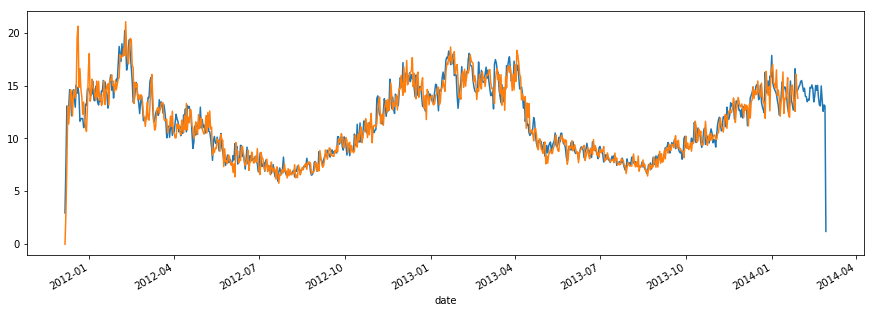

In [96]:
plt.figure(figsize=(15,5))
plt.plot(energy['date'],energy['avg'])
model_fit.fittedvalues.plot()
plt.show()

In [97]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['holiday_ind']]))
test['predicted'] = predict.values
test.tail(5)

,avg,holiday_ind,predicted
date,,,
2014-02-23,14.970731,0,12.620344
2014-02-24,13.632538,0,11.781172
2014-02-25,12.569077,0,12.281049
2014-02-26,13.169423,0,13.557734
2014-02-27,13.082385,0,12.543756


In [98]:
test['residual'] = abs(test['avg']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 1.2496197753151908
MAPE: 8.586685776941668


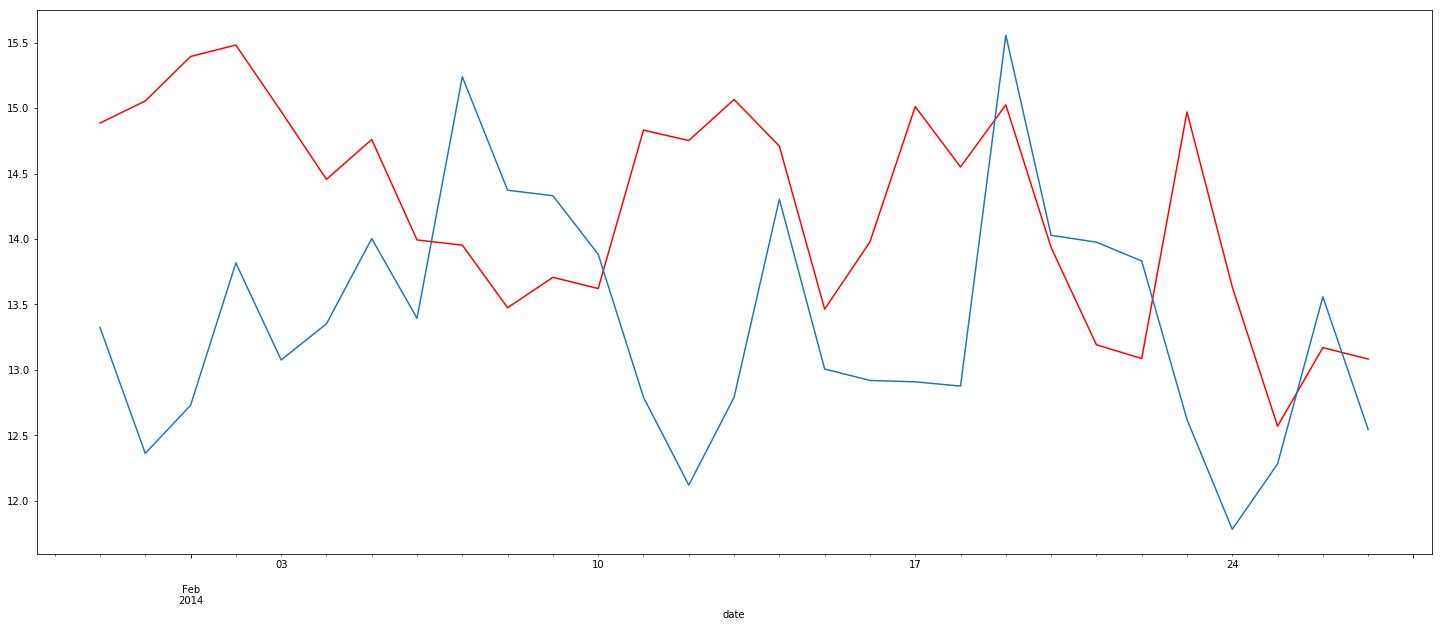

In [99]:
test['avg'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()